# This Notebook is for analyzing and processing the output of scrap

Context: Given the significant number of jobs on the LinkedIn site, it isn't easy to do an accurate search.
The search needs to be more precise, even with the site's filters.
With this, we captured this data to develop more precise ways of searching for the perfect match job.  


Solution: Scrap all job data on the LinkedIn site automatically. After collecting the data, try to develop a way to improve the search for relevant opportunities in a personalized way for each profile.  


# Libs

In [74]:
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Variables

In [43]:
all_links_path = '../data/raw/all_links.json'
all_jobs_details_path = 'data/raw/all_jobs_detail.json'

# Functions

# Loading data

In [44]:
with open(all_links_path, 'r') as openfile:
        #Reading from json file
        all_links = json.load(openfile)

In [45]:
with open(all_jobs_details_path, 'r') as openfile:
        #Reading from json file
        data_job = json.load(openfile)

# Wrangle data experiments

### Logic for capture job ids in urls

In [31]:
all_links[0]['links']

['https://www.linkedin.com/jobs/view/senior-data-scientist-at-tala-3338538962?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=itkVQcypfASexZhU95Tt5g%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/senior-data-scientist-kpm-p3723-at-84-51%CB%9A-3314238897?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=KHI3nickYQBR7OeopQDj3g%3D%3D&position=2&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/lead-data-scientist-p3719-at-84-51%CB%9A-3314239209?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=zcJINMCFRhLTJRmOCyGqhw%3D%3D&position=3&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/software-engineer-developer-productivity-at-stem-inc-3377674000?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=kAhiDeiBwGKMhhlRVAY9og%3D%3D&position=4&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/software-engineer-big-data-at-pinterest-3453

In [32]:
all_links[0]['links'][0]

'https://www.linkedin.com/jobs/view/senior-data-scientist-at-tala-3338538962?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=itkVQcypfASexZhU95Tt5g%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card'

In [33]:
unique_link = all_links[0]['links'][0]

In [34]:
# It will work, considering that every Job id will always have ten characters
re.findall(r'\d{10}', unique_link)[0]

'3338538962'

In [35]:
#capturing all Job Ids in url
all_ids = []
for l in all_links[0]['links']:
    unique_id = re.findall(r'\d{10}', l)[0]
    all_ids.append(unique_id)

In [36]:
all_ids

['3338538962',
 '3314238897',
 '3314239209',
 '3377674000',
 '3453529654',
 '3314238949',
 '3314236535',
 '3453526797',
 '3314238945',
 '3314239198',
 '3314239195',
 '3314233697',
 '3458419440',
 '3452289200',
 '3451507215',
 '3215796936',
 '3459196895',
 '3453567797',
 '3439168848',
 '2925991336',
 '3403509733',
 '3405457294',
 '3390029031',
 '3344168805',
 '3439171495']

# Data job Analysis

In [ ]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [46]:
df_job = pd.json_normalize(data_job)

In [47]:
df_job.head()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link
0,Data Scientist,"Redmond, WA",Aditi Consulting,Data Scientist,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Job Details:Title: Data ScientistLocation: Rem...,https://www.linkedin.com/jobs/view/3468551283
1,Machine Learning Engineer,United States,InterEx Group,Machine Learning Engineer,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Our client is a Fortune 500. The ideal candida...,https://www.linkedin.com/jobs/view/3476847767
2,Data Scientist,"Missouri, United States",Envision,Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting and Biotechnolog...,"***W2 Candidates Only***MS Computer Science, E...",https://www.linkedin.com/jobs/view/3477350784
3,Python Developer with AWS,United States,Maxonic,Python Developer with AWS,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Our direct client is a leading software develo...,https://www.linkedin.com/jobs/view/3467854281
4,Data Scientist,"Austin, Texas Metropolitan Area","Allied Consultants, Inc.",Data Scientist,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,"OverviewAllied Consultants, Inc. is an Austin-...",https://www.linkedin.com/jobs/view/3469869907


In [39]:
df_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                74 non-null     object
 1   location             74 non-null     object
 2   company_name         74 non-null     object
 3   position_name        74 non-null     object
 4   experience_required  74 non-null     object
 5   contract_type        74 non-null     object
 6   function_name        74 non-null     object
 7   company_sector       74 non-null     object
 8   description          74 non-null     object
 9   link                 74 non-null     object
dtypes: object(10)
memory usage: 5.9+ KB


In [85]:
df_job.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)

title
Javascript Developer                4
Data Scientist                      3
Senior Machine Learning Engineer    3
Python Developer                    3
UI Developer                        2
Sr. Data Scientist                  2
Python Developer with AWS           1
Python/AWS Developer                1
Site Reliability Engineer           1
React Developer                     1
Name: position_name, dtype: int64

Top 10 Titles offered  
High diversity title job for the same position

<AxesSubplot:xlabel='title', ylabel='position_name'>

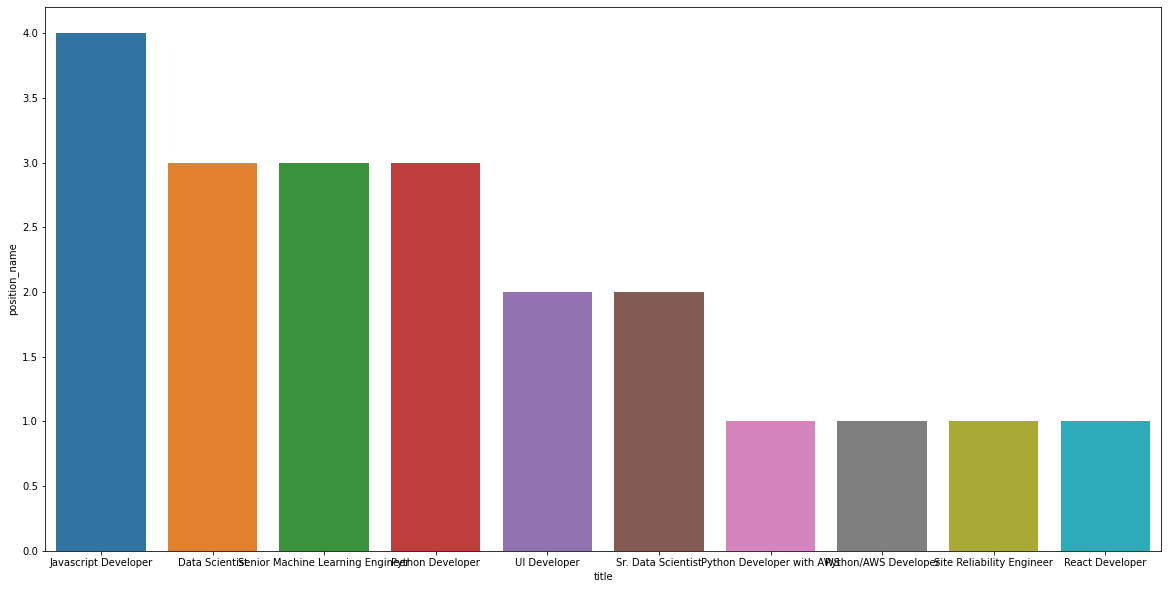

In [77]:
top_10_jobs_name = df_job.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(x = top_10_jobs_name.index , y = top_10_jobs_name)

Experiences required

In [80]:
df_job.groupby('experience_required').count()['title'].sort_values(ascending=False)

experience_required
Mid-Senior level    74
Name: title, dtype: int64

All contract type

In [81]:
df_job.groupby('contract_type').count()['title'].sort_values(ascending=False)

contract_type
Contract     73
Temporary     1
Name: title, dtype: int64

All different Function names

In [82]:
df_job.groupby('function_name').count()['title'].sort_values(ascending=False)

function_name
Information Technology                                               29
Engineering and Information Technology                               24
Engineering                                                           3
Information Technology and Engineering                                3
Consulting, Science, and Information Technology                       2
Information Technology, Engineering, and Analyst                      2
Research, Analyst, and Information Technology                         1
Project Management and Information Technology                         1
Management and Manufacturing                                          1
Information Technology, Engineering, and Research                     1
Information Technology and Business Development                       1
Information Technology, Analyst, and Engineering                      1
Consulting, Science, and Research                                     1
Finance and Sales                                 

All different company sectors

In [83]:
df_job.groupby('company_sector').count()['title'].sort_values(ascending=False)

company_sector
IT Services and IT Consulting                                                                27
Staffing and Recruiting                                                                      14
Financial Services                                                                            2
Software Development                                                                          2
Medical Equipment Manufacturing, Biotechnology Research, and Pharmaceutical Manufacturing     2
Information Services, Government Relations Services, and Government Administration            2
Banking                                                                                       1
IT Services and IT Consulting, Software Development, and Research Services                    1
Technology, Information and Internet, Insurance, and Hospitals and Health Care                1
Software Development, Computer Networking Products, and Retail                                1
Software Development and 

All different locations

In [84]:
df_job.groupby('location').count()['title'].sort_values(ascending=False)

location
United States                      46
Austin, TX                          3
New York, United States             2
Seattle, WA                         2
San Francisco, CA                   2
New Jersey, United States           2
Hershey, PA                         1
Phoenix, AZ                         1
California, United States           1
Texas, United States                1
Syracuse, NY                        1
Durham, NC                          1
Florida, United States              1
Redmond, WA                         1
Ohio, United States                 1
Los Angeles Metropolitan Area       1
Greater Boston                      1
New York, NY                        1
Austin, Texas Metropolitan Area     1
Missouri, United States             1
Minneapolis, MN                     1
Michigan, United States             1
Washington, DC                      1
Name: title, dtype: int64

Example of description

In [87]:
df_job['description'][0]

'Job Details:Title: Data ScientistLocation: RemoteDuration: 6 Months Contract (Only on W2) Required Skills:· 3-5 years of experience· Apply knowledge of machine learning techniques and concepts, including the design and implementation of advanced artificial intelligence, computational algorithms, and data science techniques.· Participate in and lead the running of experiments and documentation of results in technical or research whitepapers.· Communicates data findings to both business and IT leaders to influence how an organization approaches and meets business challenges of an evolving customer base and changing marketplace, using strong business acumen.· Collaborates with database engineers and other scientists to develop, refine, and scale data management and analytics procedures, systems, workflows, best practices, and other issues.· Conduct statistical modeling and experiment design, test and validate predictive models.· Conducts scalable data research, on and off the cloud.· Dev